In [1]:
#Generating written digits

In [112]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Flatten, Dropout, LeakyReLU, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
from tqdm import tqdm

# Generator

In [14]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)


(X_train, y_train, X_test, y_test) = load_data()

[i.shape for i in [X_train, y_train, X_test, y_test]]

[(60000, 784), (60000,), (10000, 28, 28), (10000,)]

In [114]:
#Takes a 100 length random input and transforms it into 784 pixel output

def create_generator():
    noise = Input((100,))
    x = Dense(256)(noise)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    img = Dense(784, activation='tanh')(x)
    
    model = Model(noise, img)
    model.compile(loss='binary_crossentropy', optimizer = Adam(0.0002, 0.5))
    
    return model

g = create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_117 (Dense)            (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
__________

# Discriminator

In [115]:
# Model takes a 784 pixel input and returns a single input probability value (0-1)

def create_discriminator():
    img = Input((784,))
    x = Dense(512)(img)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    validity = Dense(1, activation='sigmoid')(x)
    
    model = Model(img, validity)
    model.compile(loss='binary_crossentropy', optimizer = Adam(0.0002, 0.5))
    
    return model

d = create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


# GAN

In [89]:
def create_gan(d, g):
    #Set discriminator as non trainable
    discriminator.trainable=False
    
    #Take a 100 dim input
    gan_inp = Input(shape=(100,))
    
    #pass the 100 dim input to the discriminator to get a 784 pixel output
    x = g(gan_inp)
    
    #pass the 784 pixel input to the discriminator and get a single probability value
    gan_out = d(x)
    
    gan = Model(gan_inp, gan_out)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 100)               0         
_________________________________________________________________
model_34 (Model)             (None, 784)               227344    
_________________________________________________________________
model_35 (Model)             (None, 1)                 201217    
Total params: 428,561
Trainable params: 428,561
Non-trainable params: 0
_________________________________________________________________


In [90]:
def plot_generated_images(epoch, generator):
    noise= np.random.normal(0, 0, size = [1, 100])
    generated_image = generator.predict(noise)
    generated_image = generated_image.reshape(28,28)
    plt.figure()
    plt.imshow(generated_image, interpolation='nearest')
    plt.axis('off')
    plt.tight_layout()

Training happens in the following way, for each epoch:
1. Generate a batch of noise vector
2. Pass it through the generator to get 784 pixel images
3. Randomly pull a batch of 784 pixel images from training data
4. Concatenate them to make a batch of half real and half fake images
5. Create Y labels for this batch by setting half of them as True and rest at False
6. Set discriminator to trainable and train it on this batch
6. Set discriminator to non-trainable after the training is done
7. Generate another batch of random noise
8. Trick the GAN that these are real by providing the gan Y = 1
9. Train GAN on this batch

In [106]:
def training(epochs=1, batch_size=128, digit=5):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    
    #Selecting only the image with digit = 5, for faster computation
    (X_train, y_train, X_test, y_test) = (X_train[y_train==digit], 
                                          y_train[y_train==digit], 
                                          X_test[y_test==digit], 
                                          y_test[y_test==digit])
    
    batch_count = int(X_train.shape[0] / batch_size)
    
    # Creating GAN
    generator = create_generator()
    discriminator = create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in tqdm(range(1, epochs+1)):
        for _ in range(batch_count):
        #generate random noise as an input  to  initialize the  generator
            noise = np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X = np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise = np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 10 == 0:
           
            plot_generated_images(e, generator)

100%|█████████▉| 199/200 [02:30<00:00,  1.38it/s]/Users/akshay/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████| 200/200 [02:31<00:00,  1.36it/s]


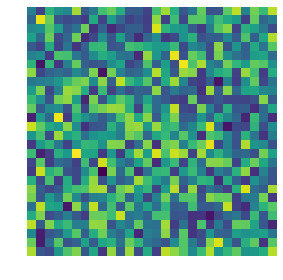

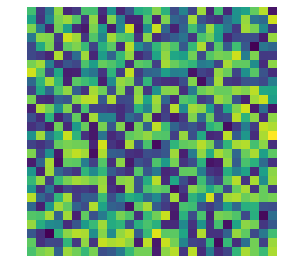

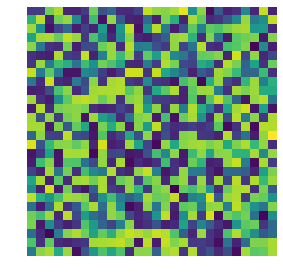

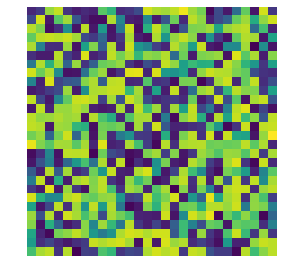

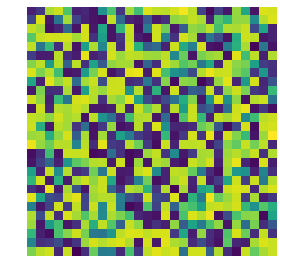

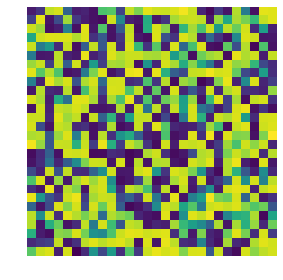

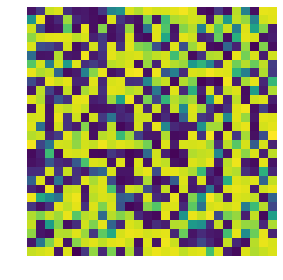

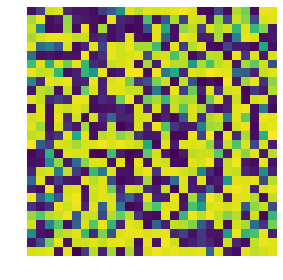

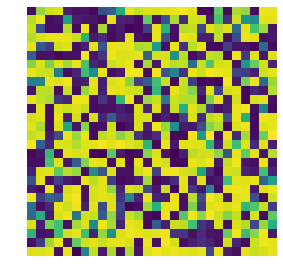

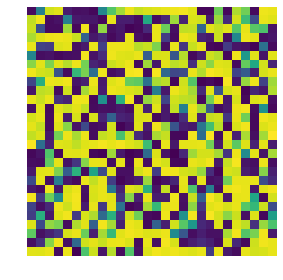

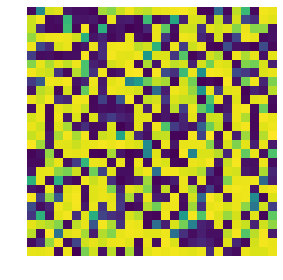

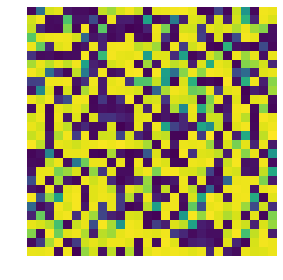

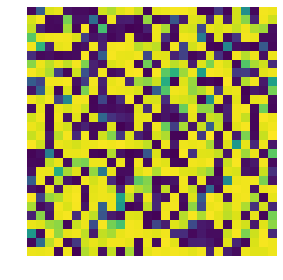

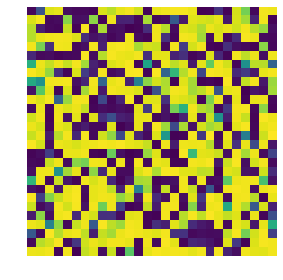

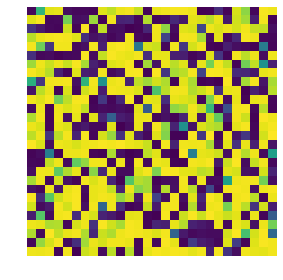

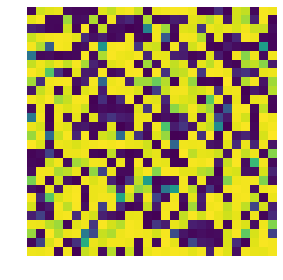

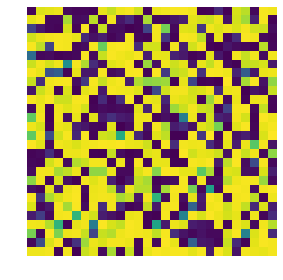

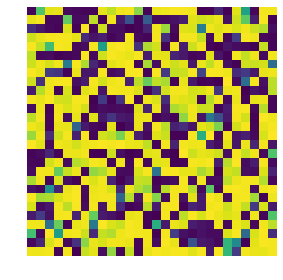

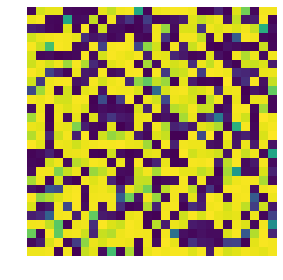

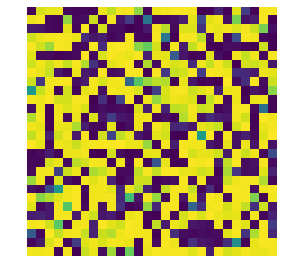

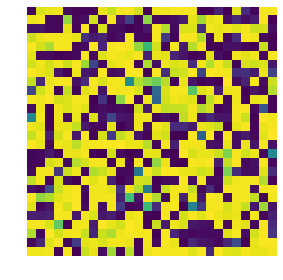

In [109]:
training(200,128)

In [32]:
nn = np.random.normal(0,1, [128, 100])

In [34]:
g.predict(nn).shape

(128, 784)

In [38]:
np.random.randint(0, 60000, 128)

array([ 5182, 42907, 48444, 39901,  7083, 30840,  9395,  3253, 43575,
       30073, 30020, 29183, 49220,  5438, 14254, 32829, 39988, 52439,
       25165,   519, 45330, 25327, 52577, 51877,  2870, 59844, 37282,
       34492, 30785,  3005, 54775, 40790, 10811, 49548,  8480, 57100,
       21232, 42769,  4378, 33288, 19877, 16905, 10623, 14010, 10368,
       35599, 25466,  6206, 28246, 30611, 15978, 44044, 26059, 12889,
       13339, 21632, 54374, 59963,  5198,  6238, 22023, 28244,  2120,
       31999, 57631, 28118, 48682, 14712, 20221, 12682, 59371, 39495,
        9429, 58816,  9377, 46148, 40007, 58257, 39376, 53866,  2717,
        5033,  9916, 44858, 28539,  3345, 21618, 54911, 44764, 12864,
       12331, 31233, 50319,  4311,  7232,  5289, 52371, 47344, 27971,
        4897, 27981, 18355, 27397, 23522, 31127, 38388, 36843, 23625,
       31449,  6787, 10925, 24132, 30252, 42923, 59265, 48436, 40030,
       43578,  3707, 45045,  9427, 44421, 44098, 11694, 12246, 25724,
       13392, 38215]

In [41]:
y_dis = np.zeros(2*128)
y_dis

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [43]:
y_dis[:128] = 0.9

In [44]:
y_dis

array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [7]:
latent_dim = 28

In [8]:
gen_inp = layers.Input((latent_dim,))
x = layers.Dense(32*14*14)(gen_inp)
x = layers.LeakyReLU()(x)
x = layers.Reshape((14,14,32))(x)
x = layers.Conv2D(64, 4, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
gen_out = layers.Conv2D(1, 8, activation='tanh', padding='same')(x)
generator = keras.Model(gen_inp, gen_out)
generator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              181888    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        32832     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv

# Discriminator

In [9]:
disc_inp = layers.Input((28,28,1))
x = layers.Conv2D(64, 3)(disc_inp)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(64, 3, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
disc_out = layers.Dense(1, activation='sigmoid')(x)
discriminator = keras.Model(disc_inp, disc_out)
discriminator.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
___________________________

In [10]:
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

In [101]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

# Training

In [ ]:
iterations = 100
batch_size = 32

In [118]:
import os

In [119]:
cwd = os.getcwd()

In [120]:
cwd

'/Users/akshay/Dropbox/Personal/Data Science/Codes/Projects/Keras'